<a href="https://colab.research.google.com/github/MillenniumForce/DATA3001/blob/main/deep_learning/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DATA3001/datascience-cis-2022.csv")
df.time = pd.to_datetime(df.time, unit="ns")
df = df.set_index("time")

In [ ]:
df

,FromInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount,FromInternetTCPPort443IPurn:ietf:params:mud:controllerPacketCount,FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount,FromInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount,FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,FromInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount,FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount,FromInternetUDPPort67IPurn:ietf:params:mud:controllerPacketCount,ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount,ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketCount,...,ToInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount,ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,ToInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount,ToInternetUDPPort1024IPurn:ietf:params:mud:controllerByteCount,ToInternetUDPPort1024IPurn:ietf:params:mud:controllerPacketCount,ToLocalUDPPort5353IP224.0.0.251/32ByteCount,ToLocalUDPPort5353IP224.0.0.251/32PacketCount,ToLocalUDPPort67IP255.255.255.255/32ByteCount,ToLocalUDPPort67IP255.255.255.255/32PacketCount,device_mac
time,,,,,,,,,,,,,,,,,,,,,
2022-09-02 00:24:59.417,0,0,0,0,0,0,0,0,3568,8,...,0,395738,957,12625992,9093,0,0,0,0,bd:0d:8e:c5
2022-09-02 00:24:59.417,0,0,0,0,71161,266,0,0,1784,4,...,11246,68385,150,0,0,0,0,0,0,bd:24:bb:1e
2022-09-02 00:24:59.417,0,0,0,0,25880,91,0,0,3568,8,...,0,103786,243,0,0,0,0,0,0,bd:0d:af:0b
2022-09-02 00:24:59.417,0,0,0,0,0,0,0,0,3568,8,...,0,29638,81,0,0,0,0,0,0,ee:dd:34:1d
2022-09-02 00:24:59.417,0,0,0,0,0,0,1400,4,1784,4,...,9857,0,0,0,0,0,0,906,2,ee:dd:39:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-16 00:23:55.620,0,0,0,0,0,0,0,0,3568,8,...,0,104138,243,0,0,0,0,0,0,bd:1c:cf:14
2022-09-16 00:23:55.620,0,0,0,0,1934,14,1400,4,1800,4,...,0,7626,15,0,0,0,0,906,2,21:fa:29:50
2022-09-16 00:23:55.620,0,0,0,0,74945,278,0,0,3568,8,...,0,0,0,25741286,18510,0,0,0,0,ee:dd:49:33


# Feature generation

features = time steps over $k$ window size (resample)

outcome = Y/N if the data belongs to the chosen network flow

In [ ]:
chosen_flow = "FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount"
window_size = 60 #i.e. 1 hour (use pca later?)

sample = df[["device_mac", "FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount"]]
sample

,device_mac,FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount
time,,
2022-09-02 00:24:59.417,bd:0d:8e:c5,0
2022-09-02 00:24:59.417,bd:24:bb:1e,71161
2022-09-02 00:24:59.417,bd:0d:af:0b,25880
2022-09-02 00:24:59.417,ee:dd:34:1d,0
2022-09-02 00:24:59.417,ee:dd:39:08,0
...,...,...
2022-09-16 00:23:55.620,bd:1c:cf:14,0
2022-09-16 00:23:55.620,21:fa:29:50,1934
2022-09-16 00:23:55.620,ee:dd:49:33,74945


In [ ]:
sample = sample.groupby("device_mac").resample("1min").sum().unstack()

In [ ]:
sample

In [ ]:
sample.columns = sample.columns.droplevel()

In [ ]:
sample.columns = np.arange(0, len(sample.columns))

In [ ]:
sample

,0,1,2,3,4,5,6,7,8,9,...,20150,20151,20152,20153,20154,20155,20156,20157,20158,20159
device_mac,,,,,,,,,,,,,,,,,,,,,
21:fa:27:56,967.0,967.0,967.0,967.0,0.0,967.0,967.0,967.0,967.0,967.0,...,967.0,967.0,967.0,967.0,967.0,2468.0,967.0,967.0,967.0,NaN
21:fa:27:82,71991.0,71310.0,78759.0,70941.0,72726.0,71035.0,75039.0,76382.0,72848.0,75039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21:fa:29:50,967.0,2887.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,...,1934.0,1934.0,1934.0,7386.0,3854.0,3854.0,3854.0,1934.0,1934.0,1934.0
21:fa:2d:cf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21:fa:2e:47,45199.0,49109.0,49391.0,45387.0,50631.0,46433.0,50605.0,45387.0,49203.0,49297.0,...,72754.0,74945.0,70663.0,69121.0,74945.0,70941.0,72726.0,70941.0,74945.0,70941.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee:dd:4e:5f,46556.0,48867.0,46838.0,48676.0,44787.0,53547.0,47375.0,46363.0,46826.0,43661.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ee:dd:4e:60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ee:dd:4f:4c,76456.0,70402.0,73066.0,74976.0,76817.0,72249.0,76955.0,71161.0,76788.0,78879.0,...,25905.0,25905.0,25905.0,25905.0,25905.0,25905.0,25905.0,0.0,25905.0,25905.0


In [ ]:
sample.iloc[:, 60:60 + window_size]

In [ ]:
batches = []

for i in range(0, len(sample.columns) - window_size, window_size):
  batches.append(sample.iloc[:, i:i+window_size].to_numpy())
  # print(i, i + window_size)

batches = np.concatenate(batches)

In [ ]:
batches = pd.DataFrame(batches)

batches["flow_type"] = chosen_flow

In [ ]:
batches

In [ ]:
# Total number of rows to expect
252255 * 22

5549610

# Split data train, val, test (0.6, 0.2, 0.2)

In [ ]:
n = len(df)
train_df = df[0:int(n*0.6)]
val_df = df[int(n*0.6):int(n*0.8)]
test_df = df[int(n*0.8):]

In [ ]:
del df

# Bulk compute all features

In [ ]:
DEVICE_MAC = "device_mac"


def construct_flow_dataframe(df, flow_type, window_size=60):
  flow_df = df[[DEVICE_MAC, flow_type]]

  # Resample to 1 minute to ensure that any time discrepencies are accounted for
  flow_df.index = flow_df.index.round("min")

  # Pivot to set time as columns
  flow_df = flow_df.reset_index() \
                   .pivot(index=DEVICE_MAC, values=flow_type, columns="time")

  # Linear interploation to fill nans
  flow_df = flow_df.interpolate(axis="columns", limit_direction="both")

  # Replace timestamps with ints for easy indexing of windows
  flow_df.columns = np.arange(0, len(flow_df.columns))

  # Using a rolling window type scheme to extract data
  # For a 60min rolling window each batch with contain 60 minutes each
  # independent from each other (this is to avoid huge amounts of data
  # from a rolling window of 0-59, 1-60, 2-61 etc. use instead 0-59, 60-119...)
  batches = []
  for i in range(0, len(flow_df.columns) - window_size, window_size):
    batches.append(flow_df.iloc[:, i:i+window_size].to_numpy())
    # print(i, i + window_size)
  batches = np.concatenate(batches)

  # Construct final dataframe
  flow_df = pd.DataFrame(batches)
  flow_df["flow_type"] = flow_type

  # ensure cleanup for memory efficiency
  del batches

  return flow_df


In [ ]:
construct_flow_dataframe(train_df, "FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount")

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,flow_type
0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,...,967.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,2468.0,FromInternetTCPPort80IPurn:ietf:params:mud:con...
1,71991.0,71310.0,78759.0,70941.0,72726.0,71035.0,75039.0,76382.0,72848.0,75039.0,...,75039.0,71035.0,74727.0,74945.0,71035.0,76852.0,70941.0,78759.0,76286.0,FromInternetTCPPort80IPurn:ietf:params:mud:con...
2,967.0,2887.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,...,967.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,FromInternetTCPPort80IPurn:ietf:params:mud:con...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort80IPurn:ietf:params:mud:con...
4,45199.0,49109.0,49391.0,45387.0,50631.0,46433.0,50605.0,45387.0,49203.0,49297.0,...,49203.0,45105.0,49203.0,49203.0,45481.0,49203.0,47480.0,47298.0,49183.0,FromInternetTCPPort80IPurn:ietf:params:mud:con...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145324,42927.0,49541.0,47293.0,42415.0,43909.0,47315.0,43183.0,45025.0,45643.0,43119.0,...,47344.0,40927.0,43154.0,40317.5,37481.0,45779.0,47785.0,45537.0,46653.0,FromInternetTCPPort80IPurn:ietf:params:mud:con...
145325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort80IPurn:ietf:params:mud:con...
145326,74883.0,74883.0,72397.0,74883.0,72882.5,70882.0,74883.0,74883.0,70882.0,74883.0,...,71074.0,66685.0,74109.0,74883.0,62804.0,75374.0,73917.0,70882.0,74883.0,FromInternetTCPPort80IPurn:ietf:params:mud:con...
145327,47837.0,43665.0,50987.0,41468.0,51744.0,46690.0,47813.0,42082.0,50505.0,45499.0,...,51723.0,37578.0,46440.0,51757.0,39949.0,48118.0,44601.0,46319.0,52920.0,FromInternetTCPPort80IPurn:ietf:params:mud:con...


In [ ]:
from multiprocessing import Pool
from tqdm.notebook import tqdm

In [ ]:
cols = train_df.columns.to_list()
cols.remove("device_mac")
cols

['FromInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount',
 'FromInternetTCPPort443IPurn:ietf:params:mud:controllerPacketCount',
 'FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
 'FromInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount',
 'FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
 'FromInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount',
 'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
 'FromInternetUDPPort67IPurn:ietf:params:mud:controllerPacketCount',
 'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
 'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketCount',
 'ToInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount',
 'ToInternetTCPPort443IPurn:ietf:params:mud:controllerPacketCount',
 'ToInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
 'ToInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount',
 'ToInternetTCPPort80IPurn:ietf:params:mud:contr

In [ ]:
from multiprocessing import cpu_count

In [ ]:
cpu_count()

2

In [ ]:
from functools import partial
from tqdm.contrib.concurrent import process_map

flow_datasets = process_map(partial(construct_flow_dataframe, test_df), 
                            cols,
                            max_workers=2, 
                            chunksize=1)

  0%|          | 0/22 [00:02<?, ?it/s]

In [ ]:
flow_datasets[2].loc[flow_datasets[2][0].isna()]

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,flow_type


In [ ]:
fld = pd.concat(flow_datasets, axis=0)
fld.columns = fld.columns.astype(str)
fld.to_parquet("/content/drive/MyDrive/DATA3001/60_min/test.parquet")

In [ ]:
fld.isna().sum()

0            0
1            0
2            0
3            0
4            0
            ..
56           0
57           0
58           0
59           0
flow_type    0
Length: 61, dtype: int64

# Inspect data

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/COMP3001/flow_dataset_60_min.parquet")

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,flow_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252250,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,ToLocalUDPPort67IP255.255.255.255/32PacketCount
252251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ToLocalUDPPort67IP255.255.255.255/32PacketCount
252252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ToLocalUDPPort67IP255.255.255.255/32PacketCount
252253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,ToLocalUDPPort67IP255.255.255.255/32PacketCount


In [ ]:
df.flow_type.nunique()

22

In [ ]:
import matplotlib.pyplot as plt

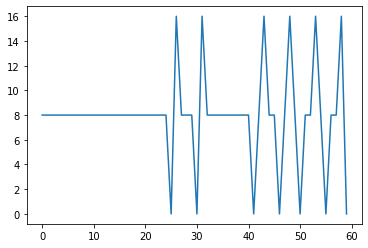

In [ ]:
plt.plot(df.loc[df.flow_type == "ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketCount"].iloc[7].to_list()[:-1])